# Basic demonstration of Pandas and Matplotlib using heat flow calorimetry data

This notebook demonstrates data import and processing of isothermal heat flow calorimetry data of C3S pastes containing two different additives. The experiments in the dataset are described in the following table.

| Experiment Code | Water Amount g | C3S Amount g | Additive Name | Additive Dosage mmol/L |
|-----------------|----------------|--------------|---------------|------------------------|
| JAA_CAL714      | 1.6            | 4            | Sucrose       | 0.25                   |
| JAA_CAL715      | 1.6            | 4            | Sucrose       | 0.5                    |
| JAA_CAL716      | 1.6            | 4            | Sucrose       | 0.75                   |
| JAA_CAL717      | 1.6            | 4            | Sucrose       | 1                      |
| JAA_CAL718      | 1.6            | 4            | Glucose       | 0.25                   |
| JAA_CAL719      | 1.6            | 4            | Glucose       | 0.5                    |
| JAA_CAL720      | 1.6            | 4            | Glucose       | 0.75                   |
| JAA_CAL721      | 1.6            | 4            | Glucose       | 1                      |
| JAA_CAL722      | 2              | 4            | Reference     | 0                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tgaedt/workshop_uv/blob/main/notebooks/0_start.ipynb)



In [19]:
%%bash

git clone --depth 1 --filter=blob:none --sparse https://github.com/tgaedt/workshop_uv.git

cd workshop_uv
git sparse-checkout set data

fatal: destination path 'workshop_uv' already exists and is not an empty directory.


# Data Exploration and Visualization of Calorimetry Data

The code above creates a folder inside the colab runtime with the calorimetry data. This is ephemeral data, i.e., it is lost when the colab runtime is shutdown (which happens automatically).

Next, we will show how the data can be loaded and plotted using conventional tools such as `pandas` and `matplotlib`. Therefore, we have to import the respective libraries. If this is run in google colab, no `pip install` is necessary as these popular libraries come pre-installed in a google colab runtime. 

## Defining folders
We use the popular library `pathlib` to define the folder containing the `.csv` files with the calorimetry data.
Furthermore, a list of dataframes can be created using a list comprehension. First, we use the glob() methof of the Path object to create a list of the filenames in the folder that end with .csv.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

folder = pathlib.Path("workshop_uv/data/calo")

[f for f in folder.glob("*.csv")]

# for f in folder.glob("*.csv"):
#     print(f)

[PosixPath('workshop_uv/data/calo/JAA_CAL716.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL720.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL722.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL715.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL717.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL718.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL714.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL719.csv'),
 PosixPath('workshop_uv/data/calo/JAA_CAL721.csv')]

Next, we create a list of dataframes, i.e., a list of which each element is itself a dataframe object.

In [ ]:
df_list = [pd.read_csv(f) for f in folder.glob("*.csv")]
df_list

The concat() method allows easy concatenation of a list of dataframes. We can thus easily transform the dataframe list into one large dataframe containing the data from all read csv files.

In [10]:
df = pd.concat(df_list)
df.head(4)

,time_s,temperature_c,heat_flow_w,heat_j,normalized_heat_flow_w_g,normalized_heat_j_g,sample,sample_short,temperature_ambientt_therm3t_c,temperature_temperature_c,comments_nan
0,3611.037066,20.0,0.000114,76.869919,0.000028,19.217480,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,NaN
1,4129.695025,20.0,0.000104,76.926600,0.000026,19.231650,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,NaN
2,4630.023150,20.0,0.000098,76.977372,0.000025,19.244343,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,NaN
3,5219.939654,20.0,0.000093,77.033889,0.000023,19.258472,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,NaN


## Plotting
The data can now easily be plotted using a for loop combined with pandas groupby. The column `sample_short` contains the filename of each original file and is a suitable grouping variable.

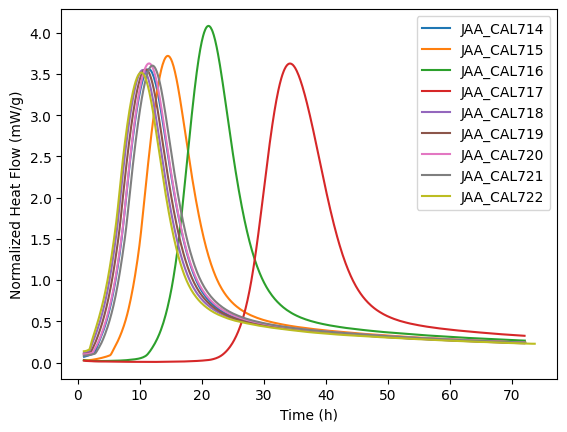

In [21]:
fig, ax = plt.subplots()
for smp, smp_df in df.groupby("sample_short"):
    ax.plot(smp_df.time_s/3600, smp_df.normalized_heat_flow_w_g*1000, label=smp)

ax.set_xlabel("Time (h)")
ax.set_ylabel("Normalized Heat Flow (mW/g)")
plt.legend()
plt.show()

This can be achieved using Seaborn as plotting library in a more straightforward approach:


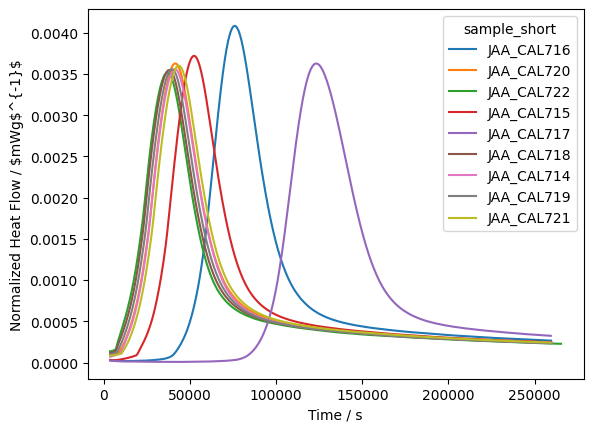

In [12]:
import seaborn as sns

sns.lineplot(data=df, x="time_s", y="normalized_heat_flow_w_g", hue="sample_short")
plt.xlabel("Time / s")
plt.ylabel("Normalized Heat Flow / $mWg$^{-1}$")
plt.show()

## Combining metadata with the calorimetry data

The metadata of these experiments is also available as a csv file in the folder `workshop_uv/data/metadata_calo/metadata.csv`. We can easily load it using the Pandas method `read_csv()`.

The data is also shown below. It contains the dosages, the dates, the name of the operator, the name of the cement, etc. 

In [13]:
metadf = pd.read_csv("workshop_uv/data/metadata_calo/metadata.csv")

metadf.head(3)

,Unnamed: 0,date,operator,number,additive_name,dosage,mmol_L,additive_amount_mg_g_cement,cement_plant,cement_type,...,art_nr,cas_nr,product_g,comment_lj,stem_solution,single_solution_mL,stem_solution_V,sample,additive_name_fixed,cement_short
0,615,2024-07-01,JAA,714,sucrose,0.25,mmol_L,NaN,C3S,C3S,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL714,Sucrose,C3S
1,616,2024-07-01,JAA,715,sucrose,0.50,mmol_L,NaN,C3S,C3S,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL715,Sucrose,C3S
2,617,2024-07-01,JAA,716,sucrose,0.75,mmol_L,NaN,C3S,C3S,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S


We now join the metadata with the experimental data. Therefore, we use the `merge()` method.

In [15]:
dfm = pd.merge(df, metadf, left_on="sample_short", right_on="sample")
dfm.head(5)

,time_s,temperature_c,heat_flow_w,heat_j,normalized_heat_flow_w_g,normalized_heat_j_g,sample_x,sample_short,temperature_ambientt_therm3t_c,temperature_temperature_c,...,art_nr,cas_nr,product_g,comment_lj,stem_solution,single_solution_mL,stem_solution_V,sample_y,additive_name_fixed,cement_short
0,3611.037066,20.0,0.000114,76.869919,0.000028,19.217480,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S
1,4129.695025,20.0,0.000104,76.926600,0.000026,19.231650,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S
2,4630.023150,20.0,0.000098,76.977372,0.000025,19.244343,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S
3,5219.939654,20.0,0.000093,77.033889,0.000023,19.258472,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S
4,5857.452837,20.0,0.000089,77.091527,0.000022,19.272882,/home/torben/LRZ Sync+Share/0_TUM/10_Coding/0_...,JAA_CAL716,NaN,NaN,...,NaN,NaN,250.0,NaN,0.01,NaN,NaN,JAA_CAL716,Sucrose,C3S


Now we are able to group our data more meaningfully than shown above. All experiments were done with C3S as the binder and two different retarding molecules: glucose and sucrose. Furthermore, the reference data without any retarder is also available. We group by the column `additive_name` first. This will create a plot for each additive. In a second nested loop, we use the variable `dosage_additive_micromol_g_cem` to group the data by the dosage used.

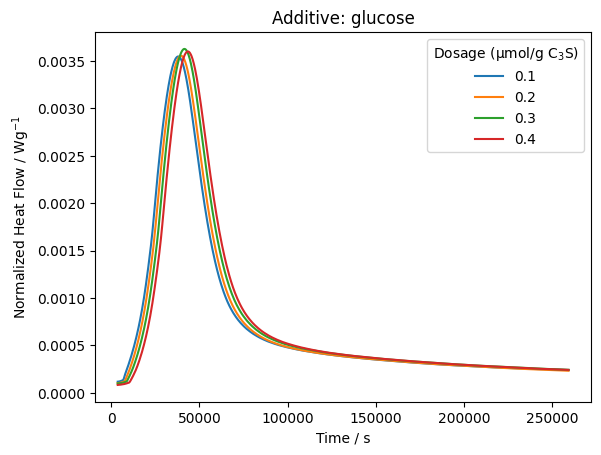

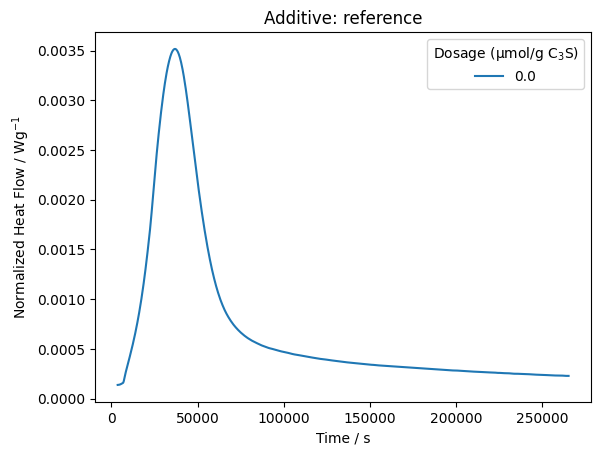

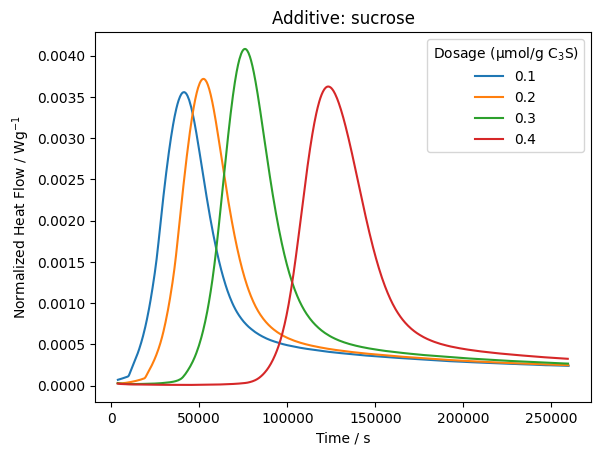

In [33]:
for additive, additive_data in dfm.groupby("additive_name"):
    fig, ax = plt.subplots()
    for dosage, dosage_data in additive_data.groupby("dosage_additive_micromol_g_cem"):
        ax.plot(dosage_data["time_s"], dosage_data["normalized_heat_flow_w_g"], label=dosage)
    ax.set_title(f"Additive: {additive}")
    ax.set_xlabel("Time / s")
    ax.set_ylabel("Normalized Heat Flow / Wg$^{-1}$")
    ax.legend(title="Dosage (µmol/g C$_{3}$S)")
    plt.show()

Another plotting option is based on seaborn. It is generally much slower than the pure matplotlib method. Some might find it more convenient to control the look and structure of these plots.

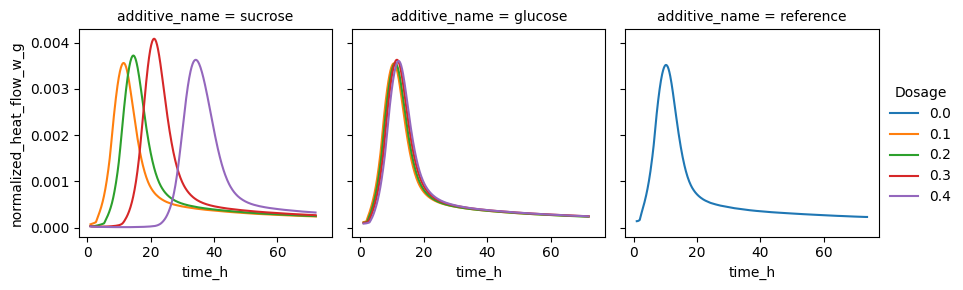

In [43]:
dfm["time_h"] = dfm["time_s"] / 3600

g = sns.FacetGrid(dfm, col="additive_name", hue="dosage_additive_micromol_g_cem", sharey=True, legend_out=True, despine=False)
g.map(sns.lineplot, "time_h", "normalized_heat_flow_w_g")
g.add_legend(title="Dosage",)

A drawback of the above plots is that the reference sample should ideally be contained in both the glucose and sucrose plots too. I.e., as the sample with a dosage of 0.0.
We need to overwrite the cells in the `additive_name` column with a list containing the names of the samples we are interested in, here we need a list `["glucose", "sucrose"]`. In the following step, we can use the `explode()` method to create new rows with the retarder names.

In [ ]:
def create_reference_data(dfm, sample_code, retarders):
    data = dfm.copy()
    mask = data["additive_name"] == sample_code
    data.loc[mask, "additive_name"] = data.loc[mask, "additive_name"].apply(lambda x: retarders)
    data = data.explode("additive_name")
    return data

retarders = ["sucrose", "glucose"]
df_ref = create_reference_data(dfm, "reference", retarders)


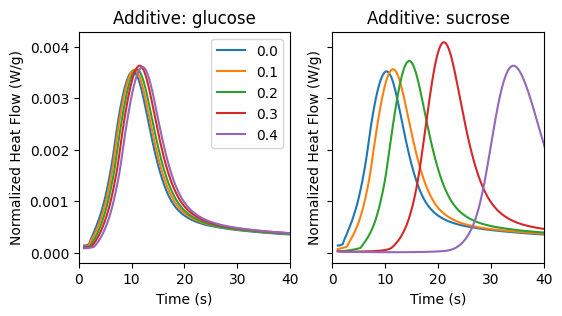

In [73]:
# Plotting
fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for (additive, additive_data), ax in zip(df_ref.groupby("additive_name"), axs.flatten()):
    
    for dosage, dosage_data in additive_data.groupby("dosage_additive_micromol_g_cem"):
        ax.plot(dosage_data["time_h"], dosage_data["normalized_heat_flow_w_g"], label=dosage)
    ax.set_title(f"Additive: {additive}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normalized Heat Flow (W/g)")
    
    ax.set_xlim(0,40)
axs[0].legend()
plt.show()